In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from PIL import Image
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
!pip install jovian --upgrade --quiet
import jovian

<IPython.core.display.Javascript object>

In [3]:
DATA_DIR = '/kaggle/input/jovian-pytorch-z2g/Human protein atlas'



TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/train'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'  

# Contains real labels for training images
TEST_CSV = DATA_DIR + '/train.csv'  

In [4]:
data_df = pd.read_csv('/kaggle/input/vgg-algorithm/train (1).csv')
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [5]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [6]:
explore = data_df.copy()
print(explore.shape)

(19236, 2)


In [7]:
def get_catcols():
    for i in range(10):
        explore[labels[i]] = explore['Label'].apply(lambda x : 1 if str(i) in str(x).split(' ') else 0)

get_catcols()

In [8]:
# this loop can be used to define weight tensor for crossentropyloss
class_wt = []
for i in list(explore.drop(['Image', 'Label'], axis=1).columns):
    class_wt.append(explore[i].sum())
class_wt_inv = torch.tensor([10000./x for x in class_wt], dtype=torch.float32)
print(class_wt_inv)
class_wt_invsqrt = torch.tensor([100./math.sqrt(x) for x in class_wt], dtype=torch.float32)
print(class_wt_invsqrt)

tensor([4.7893, 5.7078, 3.9339, 5.0582, 1.1030, 9.0171, 1.7510, 3.8037, 9.6432,
        7.8247])
tensor([2.1884, 2.3891, 1.9834, 2.2490, 1.0502, 3.0029, 1.3233, 1.9503, 3.1054,
        2.7973])


In [9]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [10]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [11]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

In [12]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#    T.RandomResizedCrop(256, scale=(0.5,1.0), ratio=(1, 1)),
#    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ToTensor(),
    T.Normalize(*imagenet_stats,inplace=True),
    T.RandomErasing(p=0.5, scale=(0.02, 0.20), ratio=(0.3, 1.5), inplace=True)
])

valid_tfms = T.Compose([
#    T.Resize(256),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

In [13]:
train_split = 0.80
np.random.seed(42)
msk = np.random.rand(len(data_df)) < train_split

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(15397, 3839)

Labels: Nuclear bodies(1) Nucleoplasm(4)


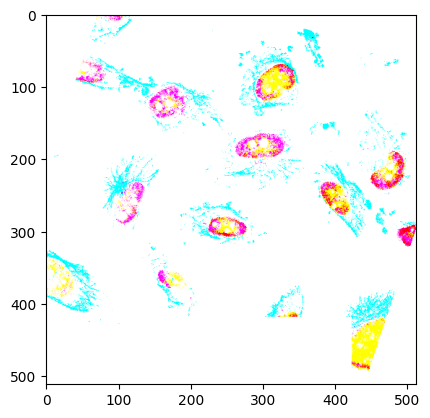

In [ ]:
show_sample(*train_ds[1])

Labels: Nuclear bodies(1) Nucleoplasm(4)


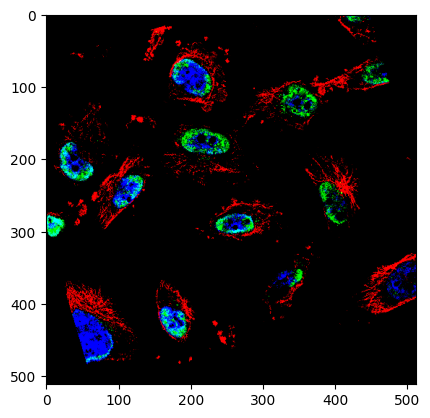

In [ ]:
show_sample(*train_ds[1], invert=False)

In [ ]:
batch_size = 8

train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

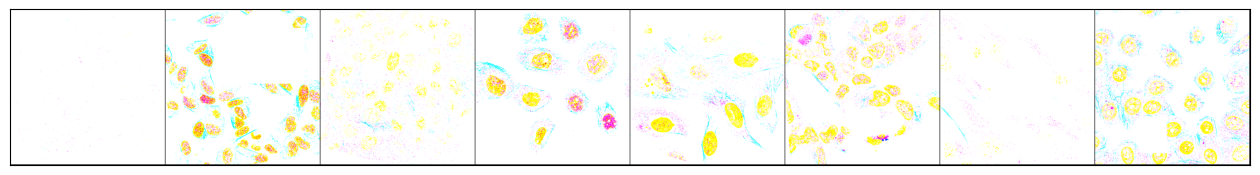

In [17]:
show_batch(train_dl, invert=True)

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [20]:
device = get_default_device()
print(device)
class_wt = to_device(class_wt_inv, device)
class_wt

cuda


tensor([4.7893, 5.7078, 3.9339, 5.0582, 1.1030, 9.0171, 1.7510, 3.8037, 9.6432,
        7.8247], device='cuda:0')

In [21]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.binary_cross_entropy(out, targets, weight=class_wt)
        return loss
    
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets, weight=class_wt)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}"
              .format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))


In [22]:
# Check the model architecture and decide how to proceed with the transfer learning
arch_view = models.vgg19_bn()
arch_view;

In [23]:
arch_view.classifier[6].parameters()

<generator object Module.parameters at 0x7bb2c33e2960>

In [24]:
class ProteinVGG19bn(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.vgg19_bn(pretrained=True)
        # Replace last layer
        num_ftrs = arch_view.classifier[6].in_features
        features = list(arch_view.classifier.children())[:-1]
        features.extend([nn.Linear(num_ftrs, 10)])
        self.network.classifier = nn.Sequential(*features)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.classifier[6].parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True


In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [28]:
model = to_device(ProteinVGG19bn(), device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:16<00:00, 35.7MB/s] 


In [29]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 3.6530961990356445, 'val_score': 0.24806450307369232}]

In [30]:
#HyperParameters
epochs = 20
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

In [32]:
print("Hello World")

Hello World


In [33]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


In [34]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

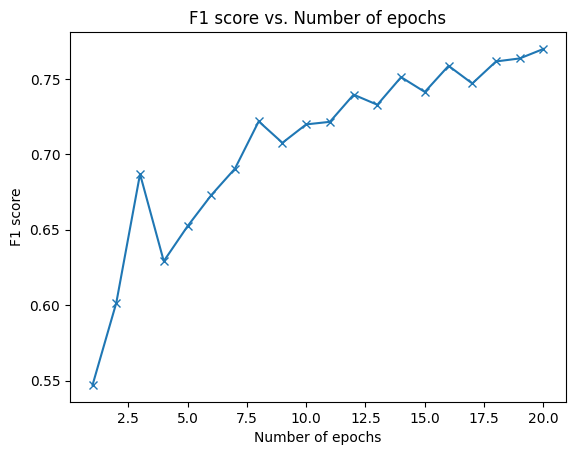

In [4]:
import matplotlib.pyplot as plt

plt.plot(number_of_epochs, VGG_val_score, '-x')
plt.xlabel('Number of epochs')
plt.ylabel('F1 score')
plt.title('F1 score vs. Number of epochs')
plt.show()


In [42]:
TEST_DIR = DATA_DIR + '/train' 
test_df = pd.read_csv('/kaggle/input/vgg-algorithm/train (1).csv')
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([2.2224e-02, 3.9701e-02, 2.3060e-02, 1.3433e-02, 9.6553e-01, 8.6486e-03,
        8.0420e-01, 2.5150e-02, 1.6147e-02, 8.8589e-04], device='cuda:0',
       grad_fn=<SelectBackward0>)
Labels: Nucleoplasm(4) Cytosol(6)


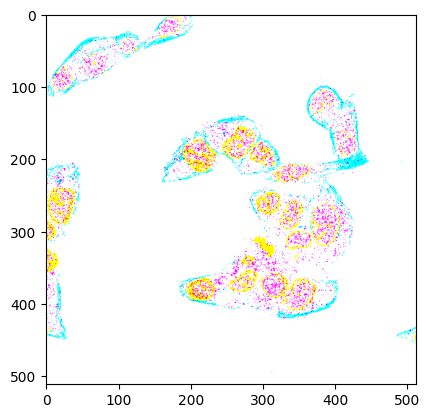

In [43]:
predict_single(test_dataset[1][0])

In [44]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([  
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, saturation=0.2, contrast=0.2),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.ToTensor()

    ])

In [45]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [46]:
test_preds = predict_dl(test_dl, model)

  0%|          | 0/2405 [00:00<?, ?it/s]

In [47]:
submission_df = pd.read_csv(TRAIN_CSV)

In [48]:
submission_df['Pred'] = test_preds

In [49]:
submission_df

,Image,Label,Pred
0,19567,9,9
1,29993,6 4,4 6
2,17186,1 4,3 4
3,29600,6 2,2 4 6
4,701,3 4,3 4
...,...,...,...
19231,428,6,6
19232,5342,6 7,7
19233,9806,4,4
19234,16112,5,5


In [55]:
submission_df.to_csv('VGG19_Pred.csv', index=False)

Prediction:  tensor([0.0103, 0.0043, 0.9603, 0.2311, 0.7073, 0.0042, 0.7894, 0.2414, 0.0134,
        0.0026], device='cuda:0', grad_fn=<SelectBackward0>)
Labels: Nucleoli(2) Nucleoplasm(4) Cytosol(6)
None


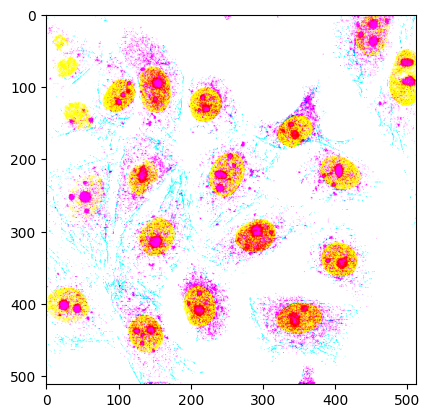

In [51]:
print(predict_single(test_dataset[3][0]))

In [52]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [56]:
submission_df

,Image,Label,Pred
0,19567,9,9
1,29993,6 4,4 6
2,17186,1 4,3 4
3,29600,6 2,2 4 6
4,701,3 4,3 4
...,...,...,...
19231,428,6,6
19232,5342,6 7,7
19233,9806,4,4
19234,16112,5,5


In [57]:
submission_df.to_csv('VGG19_Pred.csv', index=False)